# Data Preparation
The goal of this notebook is to generate sales numbers for a range of products that exhibit certain characteristics (eg. seasonality, shift, drift/trend). We use output from a Vensim simulation as a basis for these transformations.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

First we import and clean the base data.

In [2]:
data = pd.read_csv('Exporte/Tagesverkauf.csv', decimal=",", sep=";")

In [3]:
del data['Unnamed: 5']
del data['Time (Day)']

Here we add a time series component to make plotting the data easier.

In [4]:
data.insert(0, 'date', pd.Series(pd.date_range(start='1995-01-01', end='2015-07-15')))

The following lines just rename the columns.

In [5]:
def rename(name):
    if 'Produkt' in name:
        return name[0] + name[-1] + 'model'
    else:
        return name
    
data.rename(inplace=True, columns=rename)

This is what the data looks like now:

In [6]:
print(data[:5])
print('...')

        date  PAmodel  PBmodel  PCmodel  PDmodel
0 1995-01-01  1100.00  1000.00  1875.00  2850.00
1 1995-01-02  1164.59  2500.00  2940.35  3264.21
2 1995-01-03  1021.10  2410.34  1962.06  2677.24
3 1995-01-04  1047.17  2439.96  2139.77  2783.86
4 1995-01-05  1202.09  2616.01  3196.04  3417.62
...


Let's focus on ProduktA for now.

In [9]:
del data['PBmodel']
del data['PCmodel']
del data['PDmodel']

KeyError: 'PBmodel'

# Adding Seasonality
We compute a simple sine function, which peaks during summer months and has its trough in winter. Then we multiply this function with our ProduktA data in order to introduce the seasonality effect.

In [11]:
xxx = np.arange(len(data))
# simple seasonal multiplier - based on sine fn
multiplier_season = 0.05 * np.sin((1/183) * np.pi * xxx - 2) + 1
data["PAseasonal"] = data.PAmodel * multiplier_season

In [16]:
print(data[:5])
print('...')

        date  PAmodel   PAseasonal
0 1995-01-01  1100.00  1049.988642
1 1995-01-02  1164.59  1111.233893
2 1995-01-03  1021.10   973.973844
3 1995-01-04  1047.17   998.502015
4 1995-01-05  1202.09  1145.849725
...


Here is a comparison of the initial ProduktA data vs. seasonally adjusted data over a one year time span.

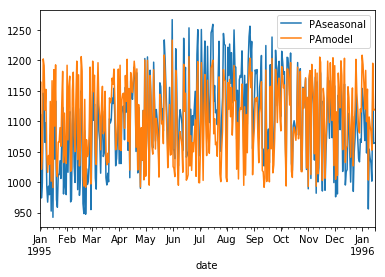

In [18]:
first_year = data[:380].set_index(data.date[:380])
first_year.plot('date', ['PAseasonal', 'PAmodel'])

To make it easier to see the effect of introducing seasonality, we plot monthly averages instead of day-by-day data. This will give us a much smoother plot. The graph below shows the seasonally adjusted data for the first four years of the time series.

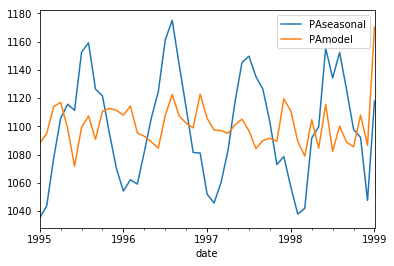

In [20]:
four_years = data[:(4*366)].set_index(data.date[:(4*366)])
four_years = four_years.resample('M').mean()
four_years.plot(y=['PAseasonal', 'PAmodel'])

# Adding a long-term trend
We might want the sales data to increase steadily over time.

In [23]:
x_trend = np.arange(len(data))
# simple 0.05% growth
multiplier_trend = 0.0005 * x_trend + 1
data["PAtrend"] = data.PAmodel * multiplier_trend

In [24]:
print(data[:5])

        date  PAmodel   PAseasonal      PAtrend
0 1995-01-01  1100.00  1049.988642  1100.000000
1 1995-01-02  1164.59  1111.233893  1165.172295
2 1995-01-03  1021.10   973.973844  1022.121100
3 1995-01-04  1047.17   998.502015  1048.740755
4 1995-01-05  1202.09  1145.849725  1204.494180


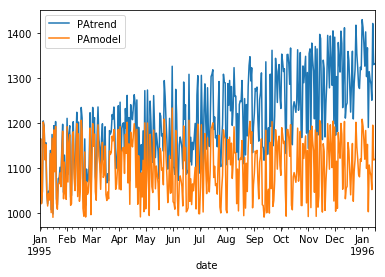

In [26]:
first_year = data[:380].set_index(data.date[:380])
first_year.plot('date', ['PAtrend', 'PAmodel'])

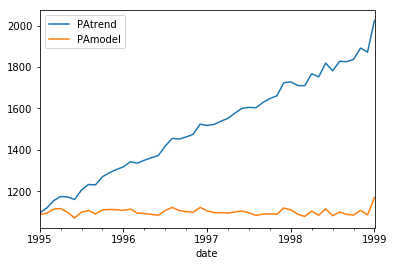

In [27]:
four_years = data[:(4*366)].set_index(data.date[:(4*366)])
four_years = four_years.resample('M').mean()
four_years.plot(y=['PAtrend', 'PAmodel'])

# Adding a one-time shift
For instance, a sudden drop in sales (-100) after the first year.

In [29]:
data["PAshift"] = data.PAmodel
data.loc[366:, ('PAshift')] = data.loc[366:, ('PAshift')] - 100

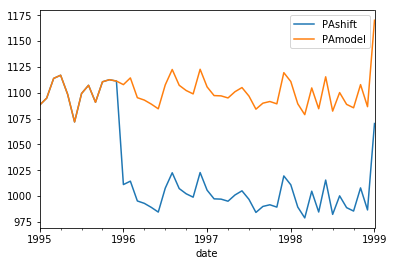

In [30]:
four_years = data[:(4*366)].set_index(data.date[:(4*366)])
four_years = four_years.resample('M').mean()
four_years.plot(y=['PAshift', 'PAmodel'])

# Combining transformations
We can create arbitrary combinations of the above to run our variance analysis on. For example, here is a series with all three combined:

In [31]:
data["PAcombi"] = data["PAshift"] * multiplier_trend * multiplier_season

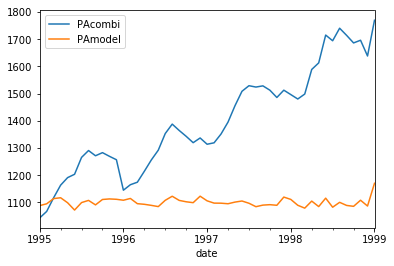

In [32]:
four_years = data[:(4*366)].set_index(data.date[:(4*366)])
four_years = four_years.resample('M').mean()
four_years.plot(y=['PAcombi', 'PAmodel'])

We end up with multiple scenarios, each with different characteristics. We could run the variance analysis on these series.

In [33]:
print(data[:5])
print('...')

        date  PAmodel   PAseasonal      PAtrend  PAshift      PAcombi
0 1995-01-01  1100.00  1049.988642  1100.000000  1100.00  1049.988642
1 1995-01-02  1164.59  1111.233893  1165.172295  1164.59  1111.789510
2 1995-01-03  1021.10   973.973844  1022.121100  1021.10   974.947817
3 1995-01-04  1047.17   998.502015  1048.740755  1047.17   999.999768
4 1995-01-05  1202.09  1145.849725  1204.494180  1202.09  1148.141424
...


Finally, we export the generated data to a CSV file.

In [34]:
data.to_csv("productA-data.csv")